### IMPORT PACKAGE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('./src/analysis')
sys.path.append('./src/data_handling')
sys.path.append('./src/modeling')
sys.path.append('./src/prediction')
sys.path.append('./src/visualization')


In [2]:
from analyzer import FeatureAnalyzer
from selector import FeatureSelector
from aggregator import DataAggregator
from feature_engineer import BatteryFeatureEngineer
from reader import BatteryDataReader
from cross_validator import CrossValidator
from evaluator import ModelEvaluator
from trainer import ModelTrainer
from predictor import Predictor
from visualizer import ResultVisualizer


## READ DATASET AND EXPLORE DATA ANALYSIS FROM RAW DATA

In [3]:
dir_data = './dataset'
battery_id = 'B0006'
df_battery_b0005 = BatteryDataReader(battery_id, dir_data)

# Load data
df_battery_b0005.load_data()
# Get raw data
df_capacity_b5, df_charge_b5, df_discharge_b5 = df_battery_b0005.get_raw_data()



--- Loading data for battery: B0006 ---
  Successfully loaded: capacity_B0006.csv
  Successfully loaded: charge_B0006.csv
  Successfully loaded: discharge_B0006.csv
--- Data loading process completed for B0006 ---


# Feature Engineering with raw data

In [4]:
fe_b5 = BatteryFeatureEngineer(
    battery_id=battery_id,
    capacity_df=df_capacity_b5,
    charge_df=df_charge_b5,
    discharge_df=df_discharge_b5
)

# Operata process feature engineering
fe_b5.process()
process_data_b5 = fe_b5.get_processed_data()



  Ensuring numeric types for B0006...
--- Starting Feature Engineering process for B0006 ---
  Calculating SOH/RUL for B0006...
  Engineering discharge features for B0006...


  Engineering charge features for B0006...


  Merging features for B0006...
  Handling NaNs for B0006...
--- Feature Engineering process finished for B0006 ---


In [8]:
fe_b5.get_all_name_feature()

['SOH',
 'RUL',
 'capacity',
 'Discharge_V_median',
 'Discharge_V_skew',
 'Discharge_T_delta',
 'Discharge_T_std',
 'Charge_T_std',
 'Time_CC_phase',
 'Time_CV_phase',
 'CV_I_end']

In [13]:
fe_b5.get_all_name_feature()

['SOH',
 'RUL',
 'capacity',
 'Discharge_V_median',
 'Discharge_V_skew',
 'Discharge_T_delta',
 'Discharge_T_std',
 'Charge_T_std',
 'Time_CC_phase',
 'Time_CV_phase',
 'CV_I_end']

In [14]:
f1 = 'Discharge_V_median'
f2 = 'Discharge_V_skew'
f3 = 'Discharge_T_delta'
f4 = 'Discharge_T_std'
f5 = 'Charge_T_std'
f6 = 'Time_CC_phase'
f7 = 'Time_CV_phase'


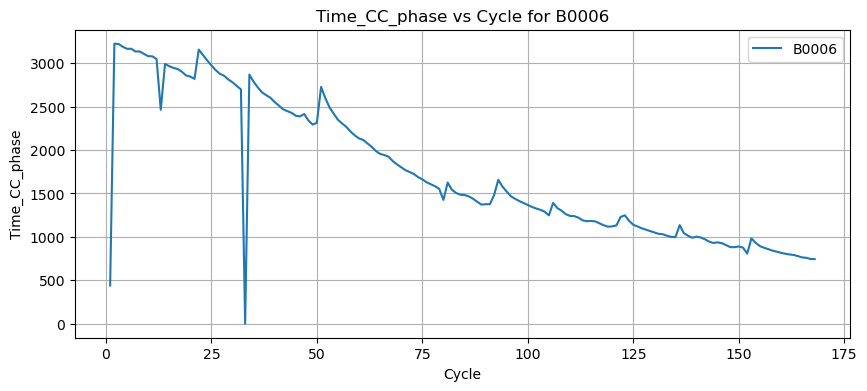

In [15]:
# Visualization feature
fe_b5.plot_feature_vs_cycle('Time_CC_phase')

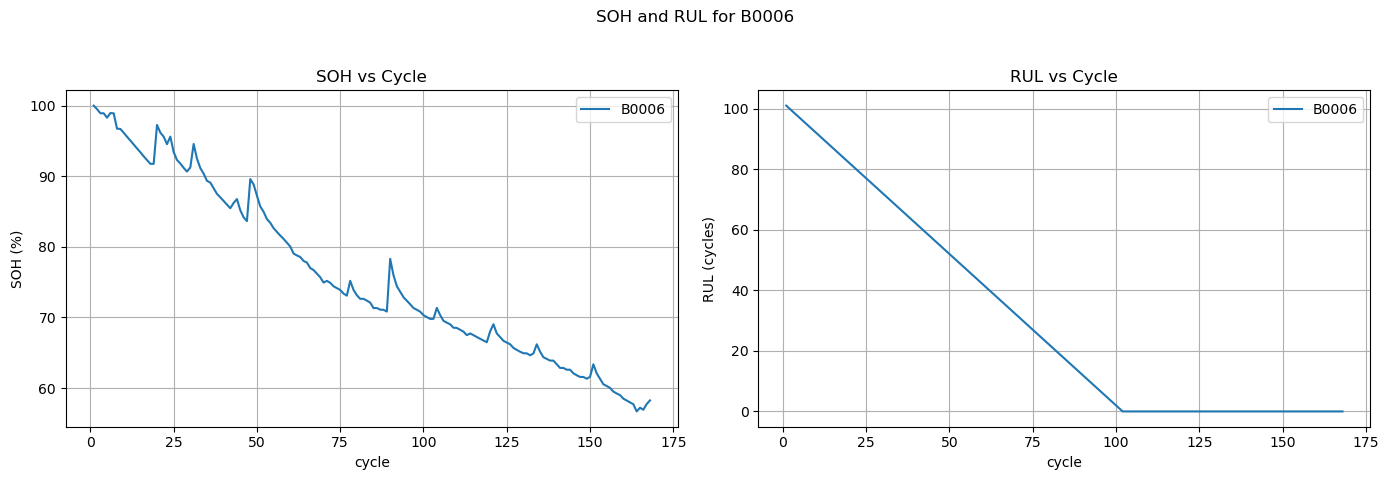

In [16]:
fe_b5.plot_soh_rul()

# Aggregation all data --> One dataFrame for model

In [5]:
battery_ids = ['B0005', 'B0006', 'B0007', 'B0018']
ACTUAL_DATA_DIR = "./dataset/"

# Update config for feature engineering
fe_configuration = {
    # Update config
}

# Init object
aggregator_df = DataAggregator(
    battery_ids=battery_ids,
    data_dir=ACTUAL_DATA_DIR,
    fe_config=fe_configuration
)



In [ ]:
# Aggregator data
aggregator_df.aggregate(force_rerun=True)

# Get data aggregator
df_combined = aggregator_df.get_combined_data()

# Check data combined
df_combined.head()

In [69]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cycle               636 non-null    int64  
 1   capacity            636 non-null    float64
 2   SOH                 636 non-null    float64
 3   RUL                 636 non-null    int64  
 4   Discharge_V_median  636 non-null    float64
 5   Discharge_V_skew    636 non-null    float64
 6   Discharge_T_delta   636 non-null    float64
 7   Discharge_T_std     636 non-null    float64
 8   Charge_T_std        636 non-null    float64
 9   Time_CC_phase       636 non-null    float64
 10  Time_CV_phase       636 non-null    float64
 11  CV_I_end            636 non-null    float64
 12  battery_id          636 non-null    object 
dtypes: float64(10), int64(2), object(1)
memory usage: 64.7+ KB


# PROCESS OUTLIER: Time_CV_phase, Time_CC_phase, Charge_T_std

In [7]:
def replace_outlier(df_processed,column_names, thresholds):
    for column_name, threshold in zip(column_names, thresholds):
        indices_below_threshold = df_processed.index[df_processed[column_name] < threshold].tolist()

        print(f"\nCác index có giá trị < {threshold}: {indices_below_threshold}")

        for idx in indices_below_threshold:
            # Kiểm tra xem có phải là hàng cuối cùng không
            if idx < len(df_processed) - 1:
                value_after = df_processed.loc[idx + 1, column_name]
                print(f" - Tại index {idx}, giá trị gốc là {df_processed.loc[idx, column_name]}.Thay bằng : {value_after}")
                df_processed.loc[idx, column_name] = value_after
        

In [8]:
df_combined_copy = df_combined.copy()

In [11]:
replace_outlier(df_combined_copy, ['Time_CV_phase', 'Time_CC_phase', 'Charge_T_std'],[6000, 500, 0.7])


Các index có giá trị < 6000: []

Các index có giá trị < 500: []

Các index có giá trị < 0.7: []


In [76]:
df_combined_copy.describe()

,cycle,capacity,SOH,RUL,Discharge_V_median,Discharge_V_skew,Discharge_T_delta,Discharge_T_std,Charge_T_std,Time_CC_phase,Time_CV_phase,CV_I_end
count,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000
mean,80.764151,1.581652,82.848168,64.726415,3.496271,-0.784519,15.626847,3.881035,1.651701,2100.275068,7942.491447,0.004810
std,47.137103,0.198765,10.930582,47.920183,0.044274,0.414000,1.232457,0.381885,0.312186,623.961511,756.346937,0.015328
min,1.000000,1.153818,56.689285,0.000000,3.408168,-2.288982,12.993038,3.111737,0.820400,743.922000,6389.750000,-0.009509
25%,40.000000,1.421123,74.806730,22.000000,3.465637,-1.061825,14.589946,3.512113,1.463067,1651.550250,7394.004000,-0.002403
50%,80.000000,1.559695,82.317809,61.500000,3.500566,-0.626749,15.652937,3.919884,1.605245,2086.601500,8006.031000,-0.000635
75%,120.000000,1.763486,92.526198,101.000000,3.536063,-0.460661,16.752268,4.230874,1.709932,2666.305000,8489.898750,0.010389
max,168.000000,2.035338,100.000000,168.000000,3.563729,-0.311294,17.655021,4.535239,2.530840,3224.844000,9612.063000,0.277994


# NORMALIZATION

In [12]:
df_combined_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cycle               636 non-null    int64  
 1   capacity            636 non-null    float64
 2   SOH                 636 non-null    float64
 3   RUL                 636 non-null    int64  
 4   Discharge_V_median  636 non-null    float64
 5   Discharge_V_skew    636 non-null    float64
 6   Discharge_T_delta   636 non-null    float64
 7   Discharge_T_std     636 non-null    float64
 8   Charge_T_std        636 non-null    float64
 9   Time_CC_phase       636 non-null    float64
 10  Time_CV_phase       636 non-null    float64
 11  CV_I_end            636 non-null    float64
 12  battery_id          636 non-null    object 
dtypes: float64(10), int64(2), object(1)
memory usage: 64.7+ KB


In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [ ]:
features_to_scale = ['Discharge_V_median', 'Discharge_V_skew','Discharge_T_delta','Discharge_T_std','Charge_T_std','Time_CC_phase'
                    ,'Time_CV_phase']
df_scaled = df_combined_copy.copy()
# --- A. StandardScaler ---
print("\n--- Sử dụng StandardScaler ---")
scaler_std = StandardScaler()
# Fit và transform trực tiếp trên các cột đã chọn của df_scaled
df_scaled[features_to_scale] = scaler_std.fit_transform(df_scaled[features_to_scale])
print("DataFrame sau khi chuẩn hóa bằng StandardScaler:")
print(df_scaled)
# In ra mean và std của các cột đã chuẩn hóa để kiểm tra
print("Mô tả thống kê các cột đã chuẩn hóa (StandardScaler):")
print(df_scaled[features_to_scale].describe().round(2)) # Mean gần 0, std gần 1

# ANALYSIS DATA 

In [ ]:
# Init object analyzer
analyzer = FeatureAnalyzer(combined_data=df_combined)

# Plot heatmap
analyzer.plot_correlation_heatmap(figsize=(8, 6), annot=False)


In [ ]:
# Get correlation value with SOH and RUL
soh_correlation = analyzer.get_correlation_with_target('SOH')

print("Top 5 Positive/Negative:")
print(soh_correlation.drop('SOH', errors='ignore').head())
print(soh_correlation.drop('SOH', errors='ignore').tail())
analyzer.plot_correlation_with_target('SOH', sort_by_abs=True, figsize=(8,6))




# CHOOSE FEATURES FOR MODEL TRAINING


In [20]:
# Init object FeatureSelector
selector = FeatureSelector(
    combined_data=df_combined,
    target_cols=['SOH', 'RUL'],
    group_col='battery_id',
    other_cols_to_exclude=['cycle','capacity']
)

FeatureSelector initialized. Columns always excluded: ['battery_id', 'capacity', 'RUL', 'cycle', 'SOH']


In [ ]:
from itertools import combinations

ff = ['Discharge_V_median','Discharge_T_delta','Discharge_T_std','Charge_T_std',
 'Time_CC_phase', 
 'Time_CV_phase']
all_subsets = []

# Lặp qua tất cả các độ dài có thể của tập con
# từ 0 (tập rỗng) đến len(ff) (chính danh sách ff)
for r in  [6, 5, 4, 3, 2, 1]:
    # Tạo các tổ hợp (combinations) có độ dài r
    # combinations trả về các tuple, nên chúng ta chuyển chúng thành list
    subsets_of_length_r = combinations(ff, r)
    for subset_tuple in subsets_of_length_r:
        all_subsets.append(list(subset_tuple))

# In ra tất cả các tập con
# for subset in all_subsets:
# print(subset)

print(f"Danh sách gốc: {ff}")
print(f"Số lượng phần tử trong danh sách gốc: {len(ff)}")
print(f"Tổng số tập con (bao gồm tập rỗng và chính nó): {len(all_subsets)}")
for x in all_subsets:
    print(x)
print(type(all_subsets))


# Training model

In [17]:
# 1. Khởi tạo Evaluator và Trainer
# Nhóm 1: "Cây Phát triển Tự do" (Nguy cơ Overfitting Cao)
params_group0 = {'n_estimators': 500, 'random_state': 42, 'n_jobs': -1,
                 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2
}

# --- 2. Định nghĩa 5 Nhóm Siêu tham số Random Forest ---
rf_base_params = {
    'random_state': 42,
    'n_jobs': -1,
    'bootstrap': True,
    'oob_score': False # oob_score không dùng với cross_val_score trực tiếp,
                      # nếu tự viết vòng lặp CV/LOBO thì có thể set True và lấy giá trị
}

# Nhóm 1: "Cấu hình Cơ bản - Baseline (Cây Tương đối Tự do)"
params_group1_rf = {
    **rf_base_params, 'n_estimators': 100, 'max_depth': None,
    'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt' # hoặc 1.0 cho hồi quy
}

# Nhóm 2: "Tăng Nhẹ Số lượng Cây và Bắt đầu Giới hạn Độ sâu"
params_group2_rf = {
    **rf_base_params, 'n_estimators': 200, 'max_depth': 15,
    'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2' # hoặc 0.7 cho hồi quy
}

# Nhóm 3: "Tập trung Kiểm soát Overfitting qua Cấu trúc Cây"
params_group3_rf = {
    **rf_base_params, 'n_estimators': 300, 'max_depth': 10,
    'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.5
}

# Nhóm 4: "Tăng cường Số lượng Cây và Tinh chỉnh max_features"
params_group4_rf = {
    **rf_base_params, 'n_estimators': 500, 'max_depth': 12, # Dựa trên kết quả nhóm 3
    'min_samples_split': 8, 'min_samples_leaf': 4,      # Dựa trên kết quả nhóm 3
    'max_features': 0.6 # Thử một giá trị khác
}


evaluator_cv_plot = ModelEvaluator(metrics_to_calculate=['mae', 'rmse', 'r2'])
trainer_cv_plot_4 = ModelTrainer(
    model_type='RandomForest',
    model_params=params_group4_rf
)
trainer_cv_plot_0 = ModelTrainer(
    model_type='RandomForest',
    model_params=params_group0
)
trainer_cv_plot_1 = ModelTrainer(
    model_type='RandomForest',
    model_params=params_group1_rf   
)
trainer_cv_plot_2 = ModelTrainer(
    model_type='RandomForest',
    model_params=params_group2_rf
)
trainer_cv_plot_3 = ModelTrainer(
    model_type='RandomForest',
    model_params=params_group3_rf
)
trainer_cv_rf_plots = [trainer_cv_plot_0, trainer_cv_plot_1, trainer_cv_plot_2, trainer_cv_plot_3, trainer_cv_plot_4]

ModelEvaluator initialized to calculate: ['rmse', 'r2', 'mae']
ModelTrainer initialized for model type: RandomForest with params: {'random_state': 42, 'n_jobs': -1, 'bootstrap': True, 'oob_score': False, 'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 0.6}
ModelTrainer initialized for model type: RandomForest with params: {'n_estimators': 500, 'random_state': 42, 'n_jobs': -1, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
ModelTrainer initialized for model type: RandomForest with params: {'random_state': 42, 'n_jobs': -1, 'bootstrap': True, 'oob_score': False, 'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
ModelTrainer initialized for model type: RandomForest with params: {'random_state': 42, 'n_jobs': -1, 'bootstrap': True, 'oob_score': False, 'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
M

# Chose optimization features for Random Forest

In [ ]:
lst_rmse_1 = []
for desired_feature in all_subsets:
    desired_features = desired_feature
    print(desired_features)
    selector.select(
        method="manual",
        config={'feature_list':desired_features}
    )
    selected_corr = selector.get_selected_features()
    df_selected = selector.get_data_with_selected_features(include_targets=True, include_group=True)
    time_col_to_use = 'cycle'
    print("\nInitializing CrossValidator for SOH...")
    cv_soh_plot = CrossValidator(
        data=df_selected,
        feature_cols=selected_corr,
        target_col='SOH',
        group_col='battery_id',
        model_trainer=trainer_cv_plot_0,
        evaluator=evaluator_cv_plot,
        cv_strategy='LOBO',
        time_col=time_col_to_use # Truyền tên cột cycle (hoặc None)
    )
        
    # 3. Chạy Cross-Validation và YÊU CẦU VẼ ĐỒ THỊ TỪNG FOLD
    cv_soh_plot.run(plot_each_fold=False) # Đặt thành True

    # 4. Lấy và hiển thị kết quả metrics SOH (đã được in trong get_metrics_summary)
    soh_metrics_summary_plot = cv_soh_plot.get_metrics_summary()
    lst_rmse_1.append(soh_metrics_summary_plot['mean']['rmse'])



In [ ]:
min_rmse_1 = min(lst_rmse_1)
y = []
x = []
min_x = 0
min_y = 0
for index, rmse_feature in enumerate(lst_rmse_1):
    x.append(index)
    y.append(rmse_feature)
    print(f'Feature: {all_subsets[index]}, RMSE: {rmse_feature}')
    if rmse_feature == min_rmse_1:
        print(f'Feature optimazation: {all_subsets[index]}, RMSE: {rmse_feature}')
        min_x = index
        min_y = rmse_feature
        continue

# Thiết lập kích thước ảnh (đơn vị: inch)
plt.figure(figsize=(8, 6))  # rộng 10 inch, cao 6 inch

# Vẽ đường
plt.plot(
    x, y,
    color='royalblue',         # Màu đường
    linewidth=2.5,             # Độ dày
    marker='o',                # Hình marker tại các điểm
    markersize=4,              # Kích thước marker
    markerfacecolor='white',   # Màu nền marker
    markeredgecolor='blue',    # Màu viền marker
    label='Dữ liệu RMSE của từng tổ hợp đặc trưng'
)

# Tiêu đề và nhãn trục
plt.title('Biểu đồ RMSE của mỗi tổ hợp đặc trưng (Random Forest)', fontsize=16)
plt.xlabel('Giá trị chỉ số của đặc trưng', fontsize=12)
plt.ylabel('Giá trị RMSE', fontsize=12)

# Vẽ điểm y nhỏ nhất với màu đỏ
plt.plot(
    min_x, min_y,
    marker='o',
    color='red',
    markersize=4,
    label='Giá trị RMSE nhỏ nhất'
)

# Ghi chú điểm nhỏ nhất
plt.text(min_x, min_y - 0.5, f'({min_x}, {min_y})', color='red', ha='center')
plt.grid(True, linestyle='--', alpha=0.4)

# Hiển thị chú thích
plt.legend()

# Tối ưu bố cục
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

In [18]:
# --- 2. Định nghĩa 5 Nhóm Siêu tham số XGBoost ---
xgb_base_params = {
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'rmse' # Theo dõi RMSE
}

# Nhóm 1: "Cấu hình Cơ bản - Baseline"
params_group1_xgb = {
    **xgb_base_params, 'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1,
    'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1
}

# Nhóm 2: "Tăng Nhẹ Độ Phức tạp và Số lượng Cây"
params_group2_xgb = {
    **xgb_base_params, 'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1,
    'gamma': 0.05, 'reg_alpha': 0, 'reg_lambda': 1
}

# Nhóm 3: "Tối ưu hóa Độ sâu và Learning Rate - Hướng tới Độ chính xác Cao hơn"
params_group3_xgb = {
    **xgb_base_params, 'n_estimators': 300, 'learning_rate': 0.02, 'max_depth': 7, # Tăng max_depth
    'subsample': 0.75, 'colsample_bytree': 0.75, 'min_child_weight': 3,
    'gamma': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.5
}

# Nhóm 4: "Tăng cường Điều chuẩn (Regularization) và Tinh chỉnh Sâu"
params_group4_xgb = {
    **xgb_base_params, 'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 5, # Giảm lại max_depth
    'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5,
    'gamma': 0.2, 'reg_alpha': 0.05, 'reg_lambda': 1.5
}

# Nhóm 5: "Thăm dò Nâng cao với Early Stopping" (Sẽ cần xử lý đặc biệt trong vòng lặp)
# Chúng ta sẽ định nghĩa các khoảng giá trị để thử nghiệm cho nhóm này sau,
# hoặc bạn có thể cố định một vài cấu hình từ các khoảng đó.
# Để đơn giản trong vòng lặp này, chúng ta sẽ tạo một cấu hình ví dụ cho Nhóm 5.
params_group5_xgb_example = {
    **xgb_base_params, 'n_estimators': 1500, 'learning_rate': 0.01, 'max_depth': 6,
    'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3,
    'gamma': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1,
}

evaluator_cv_plot = ModelEvaluator(metrics_to_calculate=['mae', 'rmse', 'r2'])
trainer_cv_xg_4 = ModelTrainer(
    model_type='XGBoost',
    model_params=params_group4_xgb
)
trainer_cv_xg_0 = ModelTrainer(
    model_type='XGBoost',
    model_params=xgb_base_params
)
trainer_cv_xg_1 = ModelTrainer(
    model_type='XGBoost',
    model_params=params_group1_xgb
)
trainer_cv_xg_2 = ModelTrainer(
    model_type='XGBoost',
    model_params=params_group2_xgb
)
trainer_cv_xg_3 = ModelTrainer(
    model_type='XGBoost',
    model_params=params_group3_xgb
)
trainer_cv_xgb_plots = [trainer_cv_xg_0, trainer_cv_xg_1, trainer_cv_xg_2, trainer_cv_xg_3, trainer_cv_xg_4]

ModelEvaluator initialized to calculate: ['rmse', 'r2', 'mae']
ModelTrainer initialized for model type: XGBoost with params: {'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'rmse', 'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'gamma': 0.2, 'reg_alpha': 0.05, 'reg_lambda': 1.5}
ModelTrainer initialized for model type: XGBoost with params: {'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'rmse'}
ModelTrainer initialized for model type: XGBoost with params: {'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'rmse', 'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
ModelTrainer initialized for model type: XGBoost with params: {'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1, '

# Chose optimization features for XGBoost

In [ ]:
lst_rmse_2 = []
for desired_feature in all_subsets:
    desired_features = desired_feature
    print(desired_features)
    selector.select(
        method="manual",
        config={'feature_list':desired_features}
    )
    selected_corr = selector.get_selected_features()
    df_selected = selector.get_data_with_selected_features(include_targets=True, include_group=True)
    time_col_to_use = 'cycle'
    print("\nInitializing CrossValidator for SOH...")
    cv_soh_plot = CrossValidator(
        data=df_selected,
        feature_cols=selected_corr,
        target_col='SOH',
        group_col='battery_id',
        model_trainer=trainer_cv_xg_0,
        evaluator=evaluator_cv_plot,
        cv_strategy='LOBO',
        time_col=time_col_to_use # Truyền tên cột cycle (hoặc None)
    )
        
    # 3. Chạy Cross-Validation và YÊU CẦU VẼ ĐỒ THỊ TỪNG FOLD
    cv_soh_plot.run(plot_each_fold=False) # Đặt thành True

    # 4. Lấy và hiển thị kết quả metrics SOH (đã được in trong get_metrics_summary)
    soh_metrics_summary_plot = cv_soh_plot.get_metrics_summary()
    lst_rmse_2.append(soh_metrics_summary_plot['mean']['rmse'])

In [ ]:
min_rmse = min(lst_rmse_2)
y = []
x = []
min_x = 0
min_y = 0
for index, rmse_feature in enumerate(lst_rmse_2):
    x.append(index)
    y.append(rmse_feature)
    print(f'Feature: {all_subsets[index]}, RMSE: {rmse_feature}')
    if rmse_feature == min_rmse:
        print(f'Feature optimazation: {all_subsets[index]}, RMSE: {rmse_feature}')
        min_x = index
        min_y = rmse_feature
        continue

# Thiết lập kích thước ảnh (đơn vị: inch)
plt.figure(figsize=(8, 6))  # rộng 10 inch, cao 6 inch

# Vẽ đường
plt.plot(
    x, y,
    color='royalblue',         # Màu đường
    linewidth=2.5,             # Độ dày
    marker='o',                # Hình marker tại các điểm
    markersize=4,              # Kích thước marker
    markerfacecolor='white',   # Màu nền marker
    markeredgecolor='blue',    # Màu viền marker
    label='Dữ liệu RMSE của từng tổ hợp đặc trưng'
)

# Tiêu đề và nhãn trục
plt.title('Biểu đồ RMSE của mỗi tổ hợp đặc trưng (XGBoost)', fontsize=16)
plt.xlabel('Giá trị chỉ số của đặc trưng', fontsize=12)
plt.ylabel('Giá trị RMSE', fontsize=12)

# Vẽ điểm y nhỏ nhất với màu đỏ
plt.plot(
    min_x, min_y,
    marker='o',
    color='red',
    markersize=4,
    label='Giá trị RMSE nhỏ nhất'
)

# Ghi chú điểm nhỏ nhất
plt.text(min_x, min_y - 0.5, f'({min_x}, {min_y})', color='red', ha='center')
plt.grid(True, linestyle='--', alpha=0.4)

# Hiển thị chú thích
plt.legend()

# Tối ưu bố cục
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

In [ ]:
mean_rmse = [(a + b) / 2 for a, b in zip(lst_rmse_1, lst_rmse_2)]
min_rmse = min(mean_rmse)
y = []
x = []
min_x = 0
min_y = 0
for index, rmse_feature in enumerate(mean_rmse):
    x.append(index)
    y.append(rmse_feature)
    print(f'Feature: {all_subsets[index]}, RMSE: {rmse_feature}')
    if rmse_feature == min_rmse:
        print(f'Feature optimazation: {all_subsets[index]}, RMSE: {rmse_feature}')
        min_x = index
        min_y = rmse_feature
        continue

# Thiết lập kích thước ảnh (đơn vị: inch)
plt.figure(figsize=(8, 6))  # rộng 10 inch, cao 6 inch

# Vẽ đường
plt.plot(
    x, y,
    color='royalblue',         # Màu đường
    linewidth=2.5,             # Độ dày
    marker='o',                # Hình marker tại các điểm
    markersize=4,              # Kích thước marker
    markerfacecolor='white',   # Màu nền marker
    markeredgecolor='blue',    # Màu viền marker
    label='Dữ liệu RMSE của từng tổ hợp đặc trưng'
)

# Tiêu đề và nhãn trục
plt.title('Biểu đồ RMSE trung bình của mỗi tổ hợp đặc trưng (XGBoost & Random Forest) trong bài toán SOH', fontsize=12)
plt.xlabel('Giá trị chỉ số của đặc trưng', fontsize=12)
plt.ylabel('RMSE (%)', fontsize=12)

# Vẽ điểm y nhỏ nhất với màu đỏ
plt.plot(
    min_x, min_y,
    marker='o',
    color='red',
    markersize=4,
    label='Giá trị RMSE nhỏ nhất'
)

# Ghi chú điểm nhỏ nhất
plt.text(min_x, min_y - 0.5, f'({min_x}, {min_y})', color='red', ha='center')
plt.grid(True, linestyle='--', alpha=0.4)

# Hiển thị chú thích
plt.legend()

# Tối ưu bố cục
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

# FINE-PARAMETER FOR RANDOM FORREST

In [ ]:

desired_features = ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
print(desired_features)
selector.select(
    method="manual",
    config={'feature_list':desired_features}
)
selected_corr = selector.get_selected_features()
df_selected = selector.get_data_with_selected_features(include_targets=True, include_group=True)
#  Khởi tạo CrossValidator cho SOH
for trainer_cv_plot in trainer_cv_rf_plots:
    time_col_to_use = 'cycle'
    print("\nInitializing CrossValidator for SOH...")
    cv_soh_plot = CrossValidator(
        data=df_selected,
        feature_cols=selected_corr,
        target_col='SOH',
        group_col='battery_id',
        model_trainer=trainer_cv_plot,
        evaluator=evaluator_cv_plot,
        cv_strategy='LOBO',
        time_col=time_col_to_use # Truyền tên cột cycle (hoặc None)
    )

    # 3. Chạy Cross-Validation và YÊU CẦU VẼ ĐỒ THỊ TỪNG FOLD
    cv_soh_plot.run(plot_each_fold=True) # Đặt thành True

    # 4. Lấy và hiển thị kết quả metrics SOH (đã được in trong get_metrics_summary)
    soh_metrics_summary_plot = cv_soh_plot.get_metrics_summary()
    



# FINE-PARAMETER FOR XGBOOST

In [ ]:
desired_features = ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']
print(desired_features)
selector.select(
    method="manual",
    config={'feature_list':desired_features}
)
selected_corr = selector.get_selected_features()
df_selected = selector.get_data_with_selected_features(include_targets=True, include_group=True)
#  Khởi tạo CrossValidator cho SOH
for trainer_cv_plot in trainer_cv_xgb_plots:
    time_col_to_use = 'cycle'
    print("\nInitializing CrossValidator for SOH...")
    cv_soh_plot = CrossValidator(
        data=df_selected,
        feature_cols=selected_corr,
        target_col='SOH',
        group_col='battery_id',
        model_trainer=trainer_cv_plot,
        evaluator=evaluator_cv_plot,
        cv_strategy='LOBO',
        time_col=time_col_to_use # Truyền tên cột cycle (hoặc None)
    )

    # 3. Chạy Cross-Validation và YÊU CẦU VẼ ĐỒ THỊ TỪNG FOLD
    cv_soh_plot.run(plot_each_fold=True) # Đặt thành True

    # 4. Lấy và hiển thị kết quả metrics SOH (đã được in trong get_metrics_summary)
    soh_metrics_summary_plot = cv_soh_plot.get_metrics_summary()

# FINAL RESULT FOR RANDOM FOREST

In [ ]:
desired_features = ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']

selector.select(
        method="manual",
        config={'feature_list':desired_features}
)
selected_corr = selector.get_selected_features()
df_selected = selector.get_data_with_selected_features(include_targets=True, include_group=True)
time_col_to_use = 'cycle'
print("\nInitializing CrossValidator for SOH...")
cv_soh_plot = CrossValidator(
    data=df_selected,
    feature_cols=selected_corr,
    target_col='SOH',
    group_col='battery_id',
    model_trainer=trainer_cv_plot_0,
    evaluator=evaluator_cv_plot,
    cv_strategy='LOBO',
    time_col=time_col_to_use # Truyền tên cột cycle (hoặc None)
)
        
# 3. Chạy Cross-Validation và YÊU CẦU VẼ ĐỒ THỊ TỪNG FOLD
data_predicted = cv_soh_plot.run(plot_each_fold=True) # Đặt thành True

# 4. Lấy và hiển thị kết quả metrics SOH (đã được in trong get_metrics_summary)
soh_metrics_summary_plot = cv_soh_plot.get_metrics_summary()
print(soh_metrics_summary_plot['mean']['rmse'])

In [40]:
print(type(data_predicted[1][0]))
data_predicted[1][3].to_csv('./result/soh_lobo/soh_lobo_rf_b0018.csv')

<class 'pandas.core.frame.DataFrame'>


In [37]:
data_predicted[1][1]

,Actual,Predicted,Group,Fold,Index
300,100.000000,98.261093,B0006,2,300
301,99.498985,97.794679,B0006,2,301
302,98.918547,97.843351,B0006,2,302
303,98.916498,97.898650,B0006,2,303
304,98.289755,97.839007,B0006,2,304
...,...,...,...,...,...
463,56.689285,70.340114,B0006,2,463
464,57.209230,70.355777,B0006,2,464
465,56.933921,70.363752,B0006,2,465
466,57.728747,72.354261,B0006,2,466


# FINAL RESULT FOR XGBOOST

In [ ]:
desired_features = ['Discharge_V_median', 'Discharge_T_std', 'Charge_T_std', 'Time_CC_phase']

selector.select(
        method="manual",
        config={'feature_list':desired_features}
)
selected_corr = selector.get_selected_features()
df_selected = selector.get_data_with_selected_features(include_targets=True, include_group=True)
time_col_to_use = 'cycle'
print("\nInitializing CrossValidator for SOH...")
cv_soh_plot = CrossValidator(
    data=df_selected,
    feature_cols=selected_corr,
    target_col='SOH',
    group_col='battery_id',
    model_trainer=trainer_cv_xg_0,
    evaluator=evaluator_cv_plot,
    cv_strategy='LOBO',
    time_col=time_col_to_use # Truyền tên cột cycle (hoặc None)
)
        
# 3. Chạy Cross-Validation và YÊU CẦU VẼ ĐỒ THỊ TỪNG FOLD
data_predicted_xgb = cv_soh_plot.run(plot_each_fold=True) # Đặt thành True

# 4. Lấy và hiển thị kết quả metrics SOH (đã được in trong get_metrics_summary)
soh_metrics_summary_plot = cv_soh_plot.get_metrics_summary()
print(soh_metrics_summary_plot['mean']['rmse'])

In [ ]:
print(data_predicted_xgb)